In [34]:
from pathlib import Path
import cv2
import numpy as np
import json
import matplotlib.pyplot as plt

In [17]:
video_input_path = 'inputs/media/Clips/'
videos = Path(video_input_path).rglob('*.mp4')
videos = [str(v) for v in videos]
# videos = [v for v in videos if 'msida' in v]
videos = [v for v in videos if 'original' in v.lower()]
# videos = [v for v in videos if 'test' in v.lower()]

count_output_path = 'outputs/counting/'


In [18]:
def convert_to_yolo(x1, y1, x2, y2, sizes):
    x_center = (x1 + x2) / 2
    y_center = (y1 + y2) / 2
    width = x2 - x1
    height = y2 - y1

    img_height, img_width = sizes
    # normalize
    x_center = x_center / img_width
    y_center = y_center / img_height
    width = width / img_width
    height = height / img_height

    return x_center, y_center, width, height


def convert_to_minmax(x_center, y_center, width, height, sizes):
    img_height, img_width = sizes
    # normalize
    x_center = x_center * img_width
    y_center = y_center * img_height
    width = width * img_width
    height = height * img_height

    x1 = x_center - width/2
    y1 = y_center - height/2
    x2 = x_center + width/2
    y2 = y_center + height/2

    # round
    x1 = round(x1)
    y1 = round(y1)
    x2 = round(x2)
    y2 = round(y2)

    return x1, y1, x2, y2


In [19]:
# # annotations_path = 'outputs/yolo5_classification_ours/'
# annotations_path = 'outputs/yolo5_classification/'
# annotation_paths = Path(annotations_path).rglob('*.txt')
# annotation_paths = [str(a) for a in annotation_paths]
# # annotation_paths = [a for a in annotation_paths if 'test' in a.lower()]
# annotation_paths

# assert len(annotation_paths) != 0, 'No annotations found'


In [20]:
# annotation_choice = 'ourYolo'
# annotation_choice = 'ogYolo'
annotation_choice = 'ground_truth'


In [21]:
if annotation_choice == 'ourYolo':
    annotations_path = 'outputs/yolo5_classification_ours/'
    annotation_paths = Path(annotations_path).rglob('*.txt')
    annotation_paths = [str(a) for a in annotation_paths]
    annotation_paths = [a for a in annotation_paths if 'original' in a.lower()] # remove background and fg

elif annotation_choice == 'ground_truth':
    annotations_path = 'inputs/annotations/'
    annotation_paths = Path(annotations_path).rglob('*.txt')
    annotation_paths = [str(a) for a in annotation_paths]
    # annotation_paths = [a for a in annotation_paths if 'original' in a.lower()] #no og in ground truth
    
elif annotation_choice == 'ogYolo':
    annotations_path = 'outputs/yolo5_classification/'
    annotation_paths = Path(annotations_path).rglob('*.txt')
    annotation_paths = [str(a) for a in annotation_paths]
    annotation_paths = [a for a in annotation_paths if 'original' in a.lower()] # remove background and fg


assert len(annotation_paths) != 0, 'No annotations found'


In [22]:
def find_centroid(x1, y1, x2, y2):
    x_center = (x1 + x2) / 2
    y_center = (y1 + y2) / 2
    return round(x_center), round(y_center)

In [23]:
def centroid_distance(x1,y1,x2,y2):
    return np.sqrt((x1-x2)**2 + (y1-y2)**2)

In [24]:
draw_bounding_boxes = True
draw_centroids = True
draw_mid_line = True    
draw_counts = True      # draw counts of cards
vis = True              #visualize everything 
save_video = False

abandoned_patience = 20 # how many frames to wait before centroid deleted
minimum_distance = 50   # distance to consider two centroids (in consecutive frames) the same
x_cutoff = 0.5          # line = x_res * this
y_cutoff = 0.5          
frameTime = 1           # delay between frames = how fast video showing

In [25]:
abandoned_objects = {}
def updateAbandoned(old_centroid_locations, object_locations):
    # copy object_locations
    object_locations_copy = object_locations.copy()
    for ix, c in old_centroid_locations.items():
        new_centroid = object_locations_copy[ix]
        if new_centroid == old_centroid_locations[ix]:
                if ix in abandoned_objects:
                    abandoned_objects[ix] += 1
                else:
                    abandoned_objects[ix] = 1
        else:
            if ix in abandoned_objects:
                abandoned_objects[ix] = 0
            else:
                abandoned_objects[ix] = 0
    
    for k, v in dict(abandoned_objects).items():
        if v > abandoned_patience:
            # print('Abandoned object:', k)
            del abandoned_objects[k]
            del object_locations[k]


In [26]:
prev_total_count = 0
def draw(frame, object_locations, left_right, right_left):
    global prev_total_count
    mid_x = round(frame.shape[1] * x_cutoff)
    mid_y = round(frame.shape[0] * y_cutoff)
    if vis:
        # cv2 show centroids
        if draw_centroids:
            for id, c in object_locations.items():
                cv2.circle(frame, (c[0], c[1]), 5, (0, 0, 255), -1)

        if draw_counts:
            # show right_left on left of frame
            cv2.putText(frame, f'{right_left}', (100, 100),cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)

            # show left_right on right of frame
            cv2.putText(frame, f'{left_right}', (frame.shape[1] - 100, 100), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)

            total_count = left_right + right_left
            
            # show total centred X
            cv2.putText(frame, f'{total_count}', (frame.shape[1]//2, 100), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)

        # draw vertical line in middle
        if draw_mid_line:
            if prev_total_count != total_count:
                cv2.line(frame, (mid_x, 0), (mid_x, frame.shape[0]), (0, 0, 255), 2)
            else:
                cv2.line(frame, (round(frame.shape[1]*x_cutoff), 0), (round(frame.shape[1]*x_cutoff), frame.shape[0]), (0, 255, 0), 2)

        prev_total_count = total_count
        cv2.imshow('frame', frame)
        if cv2.waitKey(frameTime) & 0xFF == ord('q'):
            return False
    return True, frame


In [27]:
def updateCentroids(frame, object_locations, curr_centroids, left_right, right_left):
    mid_x = round(frame.shape[1] * x_cutoff)
    mid_y = round(frame.shape[0] * y_cutoff)
         # match new centroids with old
    old_centroid_locations = {k: v for k, v in object_locations.items()}
    for ix, c in enumerate(curr_centroids):
        if len(object_locations) == 0:
            object_locations[ix] = c
        else:
            keys = list(object_locations.keys())
            next_key = max(keys) + 1
            min_centroid = next_key
            for id, o in object_locations.items():
                dist = centroid_distance(o[0], o[1], c[0], c[1])
                min_dist = minimum_distance
                if dist < min_dist:
                    min_dist = dist
                    min_centroid = id

            if min_centroid != next_key:
                old_centroid = object_locations[min_centroid]
                if old_centroid[0] <= mid_x:
                    if c[0] > mid_x:
                        left_right += 1
                elif old_centroid[0] >= mid_x:
                    if c[0] < mid_x:
                        right_left += 1

            object_locations[min_centroid] = c
    
    return old_centroid_locations, object_locations, left_right, right_left


In [28]:
def getCentroids(annotations):
    curr_centroids = []
    for a in annotations:
        a = a.split(' ')
        a = [float(x) for x in a]
        class_id = a[0]
        a = a[1:]
        x, y, w, h = a[0], a[1], a[2], a[3]
        x1, y1, x2, y2 = convert_to_minmax(
            x, y, w, h, (frame.shape[0], frame.shape[1]))
        curr_centroids.append(find_centroid(x1, y1, x2, y2))

        if vis and draw_bounding_boxes:
                cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 255, 0), 2)

    return curr_centroids

In [29]:
results = {'model': annotation_choice, 'videos': {}}

for v in videos:
    object_locations = {}
    abandoned_objects = {}
    left_right = 0
    right_left = 0
    
    
    video = cv2.VideoCapture(v)
    video_name = v.split('\\')[-1].split('.')[0]
    if 'val' in v.lower():
        continue
    if 'test' in v.lower(): set = 'Test'
    if 'train' in v.lower(): set = 'Train'
    # if set != 'Test':
    #     continue
    annotation_files = [a for a in annotation_paths if video_name.lower() in a.lower()]
    annotation_files = [a for a in annotation_files if set.lower() in a.lower()]
    sorted_annotation_files = sorted(annotation_files, key=lambda x: x.rsplit('.')[-2])


    if save_video:
        fourcc = cv2.VideoWriter_fourcc(*'XVID')
        out = cv2.VideoWriter(f'{video_name}_{set}.avi', fourcc, 30.0, (round(video.get(3)), round(video.get(4))))

    print(f'Video: {video_name} Set: {set} Frames: {int(video.get(cv2.CAP_PROP_FRAME_COUNT))} Annotations: {len(annotation_files)}')
    while True:
        ret, frame = video.read()
        if not ret:
            break
       

        curr_frame = int(video.get(cv2.CAP_PROP_POS_FRAMES))

        # print(f'Frame: {curr_frame}')
        annotation_file = annotation_files[curr_frame-1]
        annotations = open(annotation_file, 'r')
        annotations = annotations.readlines()
        annotations = [a.strip() for a in annotations]

        curr_centroids = getCentroids(annotations)
        old_centroid_locations, object_locations, left_right, right_left = updateCentroids(frame, object_locations, curr_centroids, left_right, right_left)
        updateAbandoned(old_centroid_locations, object_locations)
        toContinue, drawn_frame = draw(frame, object_locations, left_right, right_left)
        if save_video:
            out.write(drawn_frame)
        if not toContinue:
            break
        
    results['videos'][video_name+'_'+set] = {'left_right': left_right, 'right_left': right_left, 'total': left_right + right_left}


    cv2.destroyAllWindows()
    video.release()

# save results
with open(f'{count_output_path}{annotation_choice}_results.json', 'w') as f:
    json.dump(results, f, indent=4)




Video: Day_1 Set: Test Frames: 467 Annotations: 467
Video: Day_2 Set: Test Frames: 317 Annotations: 317
Video: Dry Set: Test Frames: 324 Annotations: 324
Video: Night_1 Set: Test Frames: 306 Annotations: 306
Video: Night_2 Set: Test Frames: 321 Annotations: 321
Video: Rain_1 Set: Test Frames: 314 Annotations: 314
Video: Wet_Bright Set: Test Frames: 325 Annotations: 325
Video: Wet_Dim Set: Test Frames: 317 Annotations: 317
Video: Day_1 Set: Train Frames: 1025 Annotations: 1025
Video: Day_2 Set: Train Frames: 924 Annotations: 924
Video: Dry Set: Train Frames: 1202 Annotations: 1202
Video: Night_1 Set: Train Frames: 1070 Annotations: 1070
Video: Night_2 Set: Train Frames: 915 Annotations: 915
Video: Rain_1 Set: Train Frames: 1057 Annotations: 1057
Video: Wet_Bright Set: Train Frames: 1075 Annotations: 1075
Video: Wet_Dim Set: Train Frames: 1205 Annotations: 1205


Video: Day_1_Test Predicted: 1 Ground Truth: 2
MAE: 1 MSE: 1
Video: Day_2_Test Predicted: 0 Ground Truth: 0
MAE: 0 MSE: 0
Video: Dry_Test Predicted: 1 Ground Truth: 1
MAE: 0 MSE: 0
Video: Night_1_Test Predicted: 1 Ground Truth: 0
MAE: 1 MSE: 1
Video: Night_2_Test Predicted: 0 Ground Truth: 0
MAE: 0 MSE: 0
Video: Rain_1_Test Predicted: 3 Ground Truth: 3
MAE: 0 MSE: 0
Video: Wet_Bright_Test Predicted: 3 Ground Truth: 3
MAE: 0 MSE: 0
Video: Wet_Dim_Test Predicted: 1 Ground Truth: 2
MAE: 1 MSE: 1
Video: Day_1_Train Predicted: 10 Ground Truth: 3
MAE: 7 MSE: 49
Video: Day_2_Train Predicted: 0 Ground Truth: 0
MAE: 0 MSE: 0
Video: Dry_Train Predicted: 7 Ground Truth: 8
MAE: 1 MSE: 1
Video: Night_1_Train Predicted: 1 Ground Truth: 1
MAE: 0 MSE: 0
Video: Night_2_Train Predicted: 0 Ground Truth: 0
MAE: 0 MSE: 0
Video: Rain_1_Train Predicted: 14 Ground Truth: 8
MAE: 6 MSE: 36
Video: Wet_Bright_Train Predicted: 40 Ground Truth: 20
MAE: 20 MSE: 400
Video: Wet_Dim_Train Predicted: 9 Ground Truth: 5
M

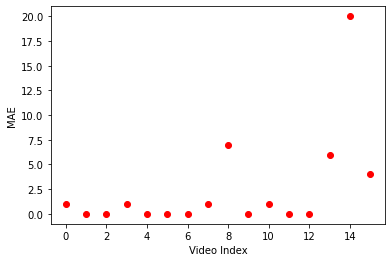

In [41]:
# find mae and mse
predicted_path = 'outputs\counting\ourYolo_results.json'
ground_truth_path = 'outputs\counting\ground_truth_results.json'

predicted_results = json.load(open(predicted_path, 'r'))['videos']
ground_truth_results = json.load(open(ground_truth_path, 'r'))['videos']

maes = []
mse = []
for video in predicted_results:
    pred_total = predicted_results[video]['total']
    gt_total = ground_truth_results[video]['total']
    print(f'Video: {video} Predicted: {pred_total} Ground Truth: {gt_total}')
    print(f'MAE: {abs(pred_total - gt_total)} MSE: {(pred_total - gt_total)**2}')
    maes.append(abs(pred_total - gt_total))
    mse.append((pred_total - gt_total)**2)
    plt.plot(list(predicted_results.keys()).index(video), abs(pred_total - gt_total), 'ro')
    plt.xlabel('Video Index')
    plt.ylabel('MAE')

    # plt.plot(abs(pred_total - gt_total), abs(gt_total), 'ro')
    # plt.xlabel('MAE')
    # plt.ylabel('Ground Truth Count')

print('-'*50)
print(f'MAE: {sum(maes)/len(maes)} MSE: {sum(mse)/len(mse)}')
print('-'*50)